In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import ensemble
from sklearn.model_selection import KFold

from mlxtend.evaluate import bias_variance_decomp

1. Придумать двумерную вероятностную модель для двух классов. Это может быть смесь нормальных распределений (с различными параметрами) с числом компонент, большим чем число классов.

In [2]:
# Количество признаков для каждгого объекта
number_of_features = 5

Генерируем данные

Пусть каждый признак имеет нормальное распределение с различными параметрами (будем генерировать на основе заданных
среднего и стандартного отклонений для каждого признака)
И так для каждого признака каждого из двух классов

In [3]:
def generate_dataframe(class1_count, class2_count):
    
    # Средние значения
    means1 = [0.25, 0.15, -0.22, 0.21, 0.27]
    means2 = [0.23, -0.2, 0.28, -0.23, 0.25]
    # Стандартные отклонения
    devs1 = [0.13, 0.22, 0.13, 0.22, 0.51]
    devs2 = [0.15, 0.22, 0.42, 0.21, 0.23]
    
    features1 = np.random.normal(loc = means1, scale = devs1, size=[class1_count, number_of_features])
    features2 = np.random.normal(loc = means2, scale = devs2, size=[class2_count, number_of_features])
    
    df = pd.DataFrame()
    df['class'] = np.concatenate((np.full(class1_count, 0), np.full(class2_count, 1)))
    
    for i in range(0, number_of_features):
        df['feature' + str(i)] = np.concatenate((features1[:, i], features2[:, i]))
        
    return df

In [4]:
df = generate_dataframe(100, 100)
df

,class,feature0,feature1,feature2,feature3,feature4
0,0,0.344606,0.183192,-0.297009,0.247524,0.497708
1,0,0.100363,0.293157,-0.264004,0.096526,0.190967
2,0,0.227713,0.256151,-0.367108,0.459370,0.672347
3,0,0.182080,0.527413,-0.227836,0.295002,1.120675
4,0,0.272484,0.290213,-0.083839,-0.111963,-0.854476
...,...,...,...,...,...,...
195,1,0.255740,0.209369,0.212136,-0.104691,-0.019905
196,1,0.289154,0.161170,0.336015,-0.417836,0.303995
197,1,0.226751,-0.061175,0.464665,-0.024992,-0.387667
198,1,0.181996,-0.195390,0.055734,-0.175758,0.160317


Построим распределение для каждого признака

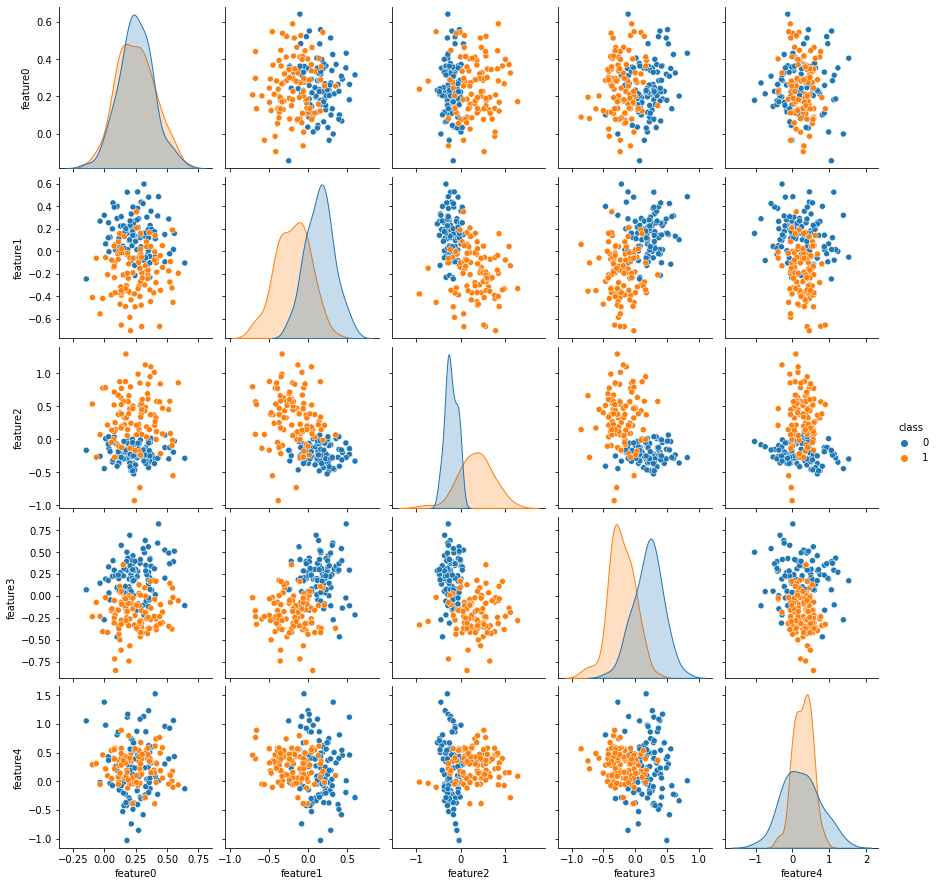

In [5]:
sns.pairplot(df, hue='class')

2. Задать параметры: размер обучающей выборки (порядка 100 объектов), число разбиений кроссвалидации. Выбрать метод классификации и задать его параметры.
3. Повторять шаги 4–7 заданное число раз (50–100).
4. Сгенерировать обучающую выборку заданного размера.
5. Построить решающую функцию. Вычислить эмпирический риск (число ошибок на обучении).
6. Сгенерировать контрольную выборку достаточно большого размера (больше 10000 объектов). Вычислить оценку вероятности ошибочной классификации.
7. Вычислить оценку вероятности ошибочной классификации методом скользящего экзамена (на исходной обучающей выборке).


Эмпирический риск:
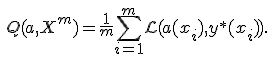

Вероятность ошибочной классификации:
p = test_errors_count / all_tests_samples_count

Оценки вероятности ошибочной классификации методом скользящего среднего (кросс-валидация):
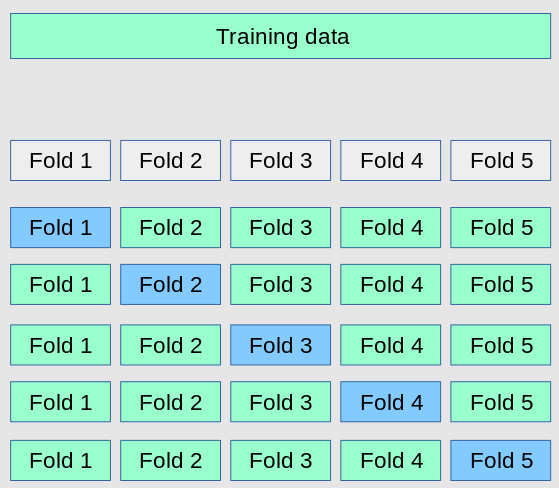

Будем использовать random forest в качестве метода классификации

Random Forest - классификатор, использующий в качестве усредненный результат классификации множества деревьев решений (Decision Tree)

Decision Tree - классификатор, представляющий собой дерево принятия решений на ветвление которого происходит на основании выбора наиболее информативных признаков и пороговых значений для них
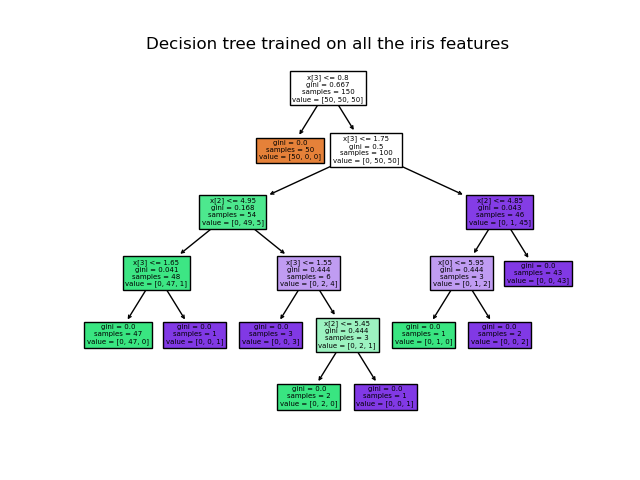

In [6]:
# parameters:
# *n_estimators* - кол-во дереьев решений
# *max_depth* - ограничение на максимальную глубину дерева
# *max_samples* - количество выборок для бутстрапа

classifier = ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50)

Бутстрап:
1. Равномерно возьмем из выборки  L  объектов с возвращением (из-за возвращения среди них окажутся повторы)
2. Повторив процедуру  N  раз, сгенерируем  N  подвыборок  X1,...,XN .
3. Обучим по каждой из них модель

,empirical_risk,error_prob,moving_average
0,0.040,0.06110,0.065
1,0.035,0.06510,0.070
2,0.025,0.06545,0.125
3,0.025,0.05880,0.080
4,0.020,0.05420,0.085
...,...,...,...
65,0.015,0.05400,0.095
66,0.020,0.05245,0.055
67,0.020,0.06725,0.100
68,0.035,0.06860,0.140


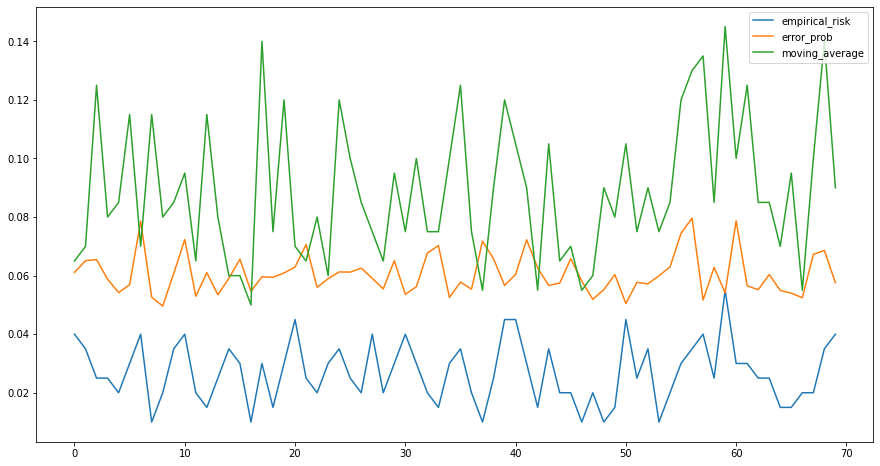

In [7]:
def count_errors(preds, gts):
    errors = 0
    for pred, gt in zip(preds, gts):
        if pred != gt:
            errors += 1
    return errors

def calculate_statistics(classifier):
    n = 70

    results = pd.DataFrame()
    results['empirical_risk'] = np.zeros(n)
    results['error_prob'] = np.zeros(n)
    results['moving_average'] = np.zeros(n)

    for i in range(n):
        df = generate_dataframe(100, 100)

        X = df.iloc[:, 1:]
        y = df['class']

        classifier.fit(X, y)
        predict = classifier.predict(X)
        
        # Расчет эмпирического риска
        errors = count_errors(predict, y)
        results['empirical_risk'][i] = errors / len(predict)
        
        # Расчет оценки вероятности ошибочной классификации
        # Генерируем новую выборку из большего кол-ва объектов
        df_test = generate_dataframe(10000, 10000)
        predict = classifier.predict(df_test.iloc[:, 1:])
        results['error_prob'][i] = count_errors(predict, df_test['class']) / len(predict)
        
        # Расчет оценки вероятности ошибочной классификации методом скользящего среднего:
        # Усредняем значение вероятностей полученных для каждого k-fold
        errors = []
        kf = KFold(n_splits=5, shuffle=False)
        for train_index, test_index in kf.split(y):
            X_train_sub = np.take(X, train_index, axis=0)
            X_test_sub = np.take(X, test_index, axis=0)
            y_train_sub = np.take(y, train_index)
            y_test_sub = np.take(y, test_index)
            classifier.fit(X_train_sub, y_train_sub)
            predict = classifier.predict(X_test_sub)
            errors.append(count_errors(predict, y_test_sub) / len(predict))

        results['moving_average'][i] = np.mean(errors)

    return results


res = calculate_statistics(classifier)
plt.rcParams['figure.figsize'] = (15,8)
plt.plot(res['empirical_risk'])
plt.plot(res['error_prob'])
plt.plot(res['moving_average'])
plt.legend(('empirical_risk', 'error_prob', 'moving_average'), loc='upper right')
plt.show
res

9. Вычислить средние и стандартные отклонения по каждому столбцу.

In [8]:
statistics = pd.DataFrame()
statistics['metric'] = ['mean', 'std_dev']
statistics['empirical_risk'] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
statistics['error_prob'] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
statistics['moving_average'] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]

statistics

,metric,empirical_risk,error_prob,moving_average
0,mean,0.026929,0.060571,0.088857
1,std_dev,0.010292,0.006893,0.023802


Среди всех оценок ошибочной классификации оценка на основе эмпирического риска на обучающей выборке наименее информативна из всех трех, поскольку при переобучении его значение будет значительно снижаться.

Оценка методом скользящего среднего на обучающей выборке более информативна, чем оченка эмпирического риска на обучающей выборке, т. к. валидация происходит на данных, на которых не производилось обучение, следовательно, переобучение не будет закономерно снижать значение данной оценки.
Наибольшие, среди представленных трех, флуктуации значения данной оценки но обуславливаются небольшой выборкой данных как для обучения, так и для валидации.

Оценка вероятности ошибочной классификации на новых данных более устойчива за счет их количества, на 2 порядка превосходящего кол-во тренировочных данных.

10. Провести аналогичное моделирование, изменив вероятностную модель, или метод классификации, или параметры метода.
11. Сделать выводы, насколько выбранный метод классификации и его параметры соответствуют сложности модели и объёму выборки.


Рассмотрим зависимость оценок от параметров метода классификации

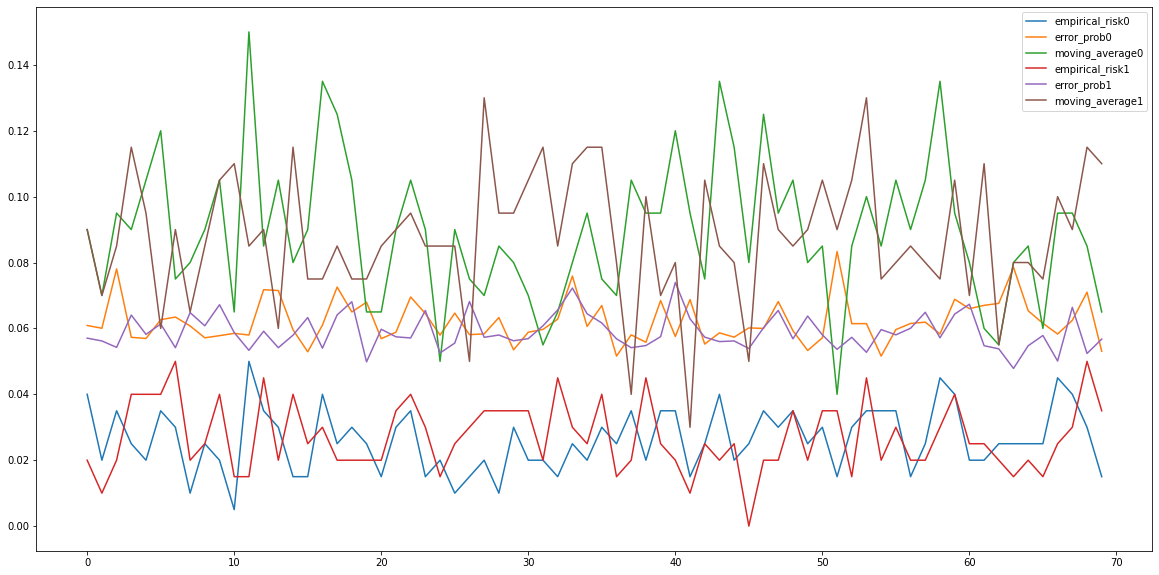

,metric,empirical_risk0,error_prob0,moving_average0,empirical_risk1,error_prob1,moving_average1
0,mean,0.026214,0.062181,0.089143,0.027143,0.058967,0.087929
1,std_dev,0.009466,0.006476,0.021314,0.010473,0.005252,0.019649


In [9]:
# max_depth

classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=50, random_state=0, max_samples=50)]


statistics = pd.DataFrame()
plt.rcParams['figure.figsize'] = (20,10)
for i in range(len(classifiers)):
    res = calculate_statistics(classifiers[i])
    
    res['empirical_risk' + str(i)] = res['empirical_risk']
    res['error_prob' + str(i)] = res['error_prob']
    res['moving_average' + str(i)] = res['moving_average']
    
    plt.plot(res['empirical_risk' + str(i)])
    plt.plot(res['error_prob' + str(i)])
    plt.plot(res['moving_average' + str(i)]) 
    statistics['metric'] = ['mean', 'std_dev']
    statistics['empirical_risk' + str(i)] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
    statistics['error_prob' + str(i)] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
    statistics['moving_average' + str(i)] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]
    
legend = []
for i in range(len(classifiers)):
    legend.append('empirical_risk' + str(i))
    legend.append('error_prob' + str(i))
    legend.append('moving_average' + str(i))
    
plt.legend((legend), loc='upper right')
plt.show()

statistics

Изменение максимальной глубины дерева практически не оказывает влияния на вероятность ошибочной классификации, что говорит о том, что для конкретных данных достаточно глубины дерева < 10

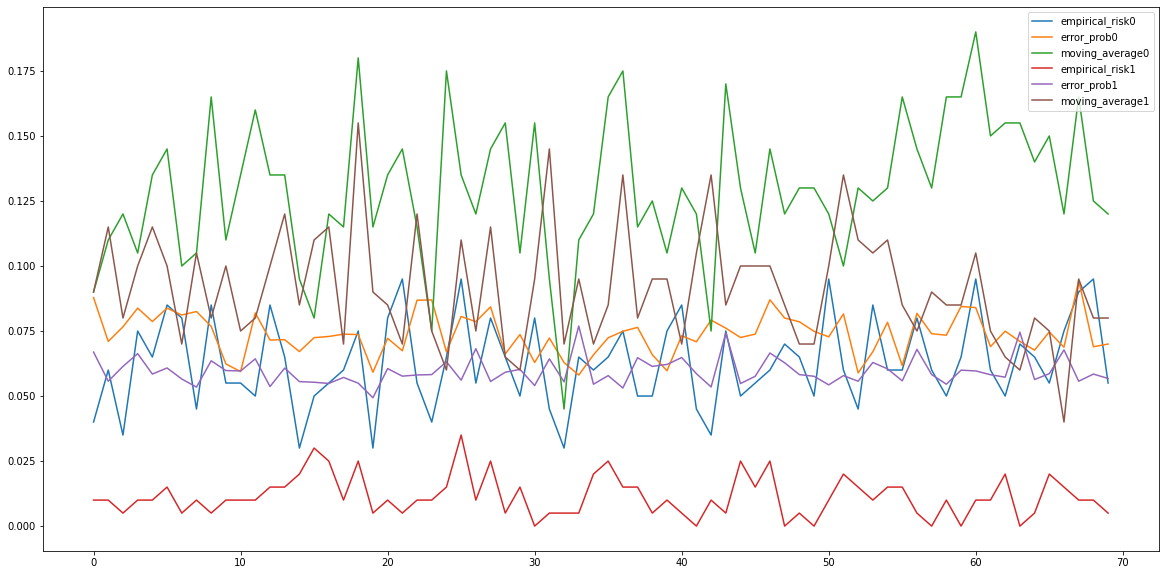

,metric,empirical_risk0,error_prob0,moving_average0,empirical_risk1,error_prob1,moving_average1
0,mean,0.063071,0.073808,0.129571,0.011357,0.059566,0.091571
1,std_dev,0.016909,0.007896,0.027383,0.007696,0.005216,0.021639


In [10]:
# max_samples

classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=10),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=100)]


statistics = pd.DataFrame()
plt.rcParams['figure.figsize'] = (20,10)
for i in range(len(classifiers)):
    res = calculate_statistics(classifiers[i])
    
    res['empirical_risk' + str(i)] = res['empirical_risk']
    res['error_prob' + str(i)] = res['error_prob']
    res['moving_average' + str(i)] = res['moving_average']
    
    plt.plot(res['empirical_risk' + str(i)])
    plt.plot(res['error_prob' + str(i)])
    plt.plot(res['moving_average' + str(i)]) 
    statistics['metric'] = ['mean', 'std_dev']
    statistics['empirical_risk' + str(i)] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
    statistics['error_prob' + str(i)] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
    statistics['moving_average' + str(i)] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]
    
legend = []
for i in range(len(classifiers)):
    legend.append('empirical_risk' + str(i))
    legend.append('error_prob' + str(i))
    legend.append('moving_average' + str(i))
    
plt.legend((legend), loc='upper right')
plt.show()

statistics

Увеличение количества выборок для бутстрапа уменьшает вероятность ошибки и увеличивает вероятность переобучения, о последнем может свидетельствовать значительное уменьшение эмпирического риска 

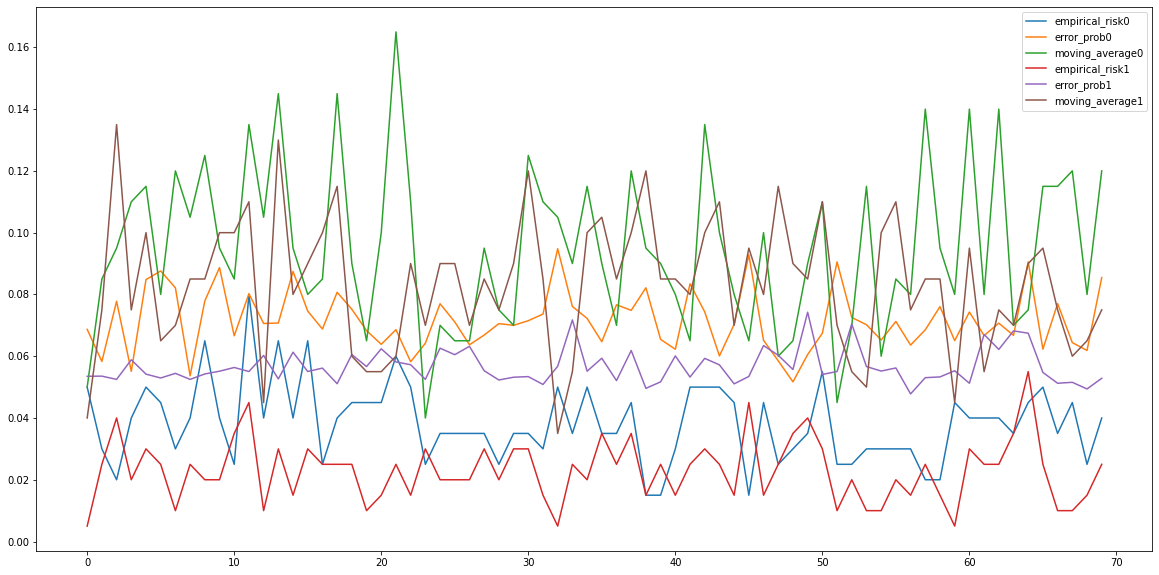

,metric,empirical_risk0,error_prob0,moving_average0,empirical_risk1,error_prob1,moving_average1
0,mean,0.038357,0.071626,0.095000,0.023000,0.056686,0.083286
1,std_dev,0.012613,0.009534,0.026295,0.009979,0.005436,0.021379


In [11]:
# n_estimators

classifiers = [ensemble.RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_samples=50)]


statistics = pd.DataFrame()
plt.rcParams['figure.figsize'] = (20,10)
for i in range(len(classifiers)):
    res = calculate_statistics(classifiers[i])
    
    res['empirical_risk' + str(i)] = res['empirical_risk']
    res['error_prob' + str(i)] = res['error_prob']
    res['moving_average' + str(i)] = res['moving_average']
    
    plt.plot(res['empirical_risk' + str(i)])
    plt.plot(res['error_prob' + str(i)])
    plt.plot(res['moving_average' + str(i)]) 
    statistics['metric'] = ['mean', 'std_dev']
    statistics['empirical_risk' + str(i)] = [ np.mean(res.iloc[:,0]) , np.std(res.iloc[:,0])]
    statistics['error_prob' + str(i)] = [ np.mean(res.iloc[:,1]) , np.std(res.iloc[:,1])]
    statistics['moving_average' + str(i)] = [ np.mean(res.iloc[:,2]) , np.std(res.iloc[:,2])]
    
legend = []
for i in range(len(classifiers)):
    legend.append('empirical_risk' + str(i))
    legend.append('error_prob' + str(i))
    legend.append('moving_average' + str(i))
    
plt.legend((legend), loc='upper right')
plt.show()

statistics

Увеличение кол-ва деревьев ведет к уменьшению вероятности ошибочной классификации, модель стала более устойчивой т.к. было увеличено количество голосующих "подмоделей"

12. Факультативно: вычислить смещение и разброс (bias-variance decomposition)

Bias характеризует недообучение. Его высокое значение говорит о том, что алгоритм учитывает не все связи между функциями и целевыми выходными данными.

Variance — характеризует переобучение. Высокий variance говорит о чувствительности модели к небольшим колебаниям обучающей выборки.

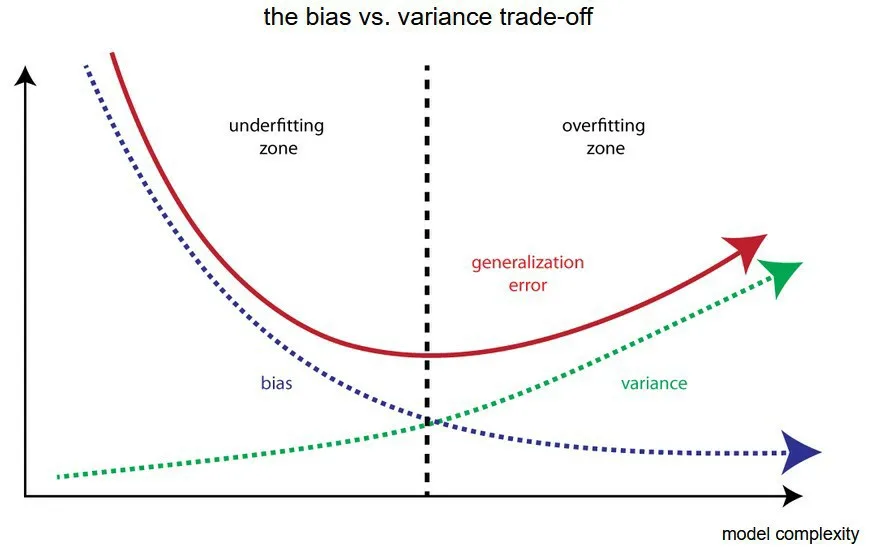
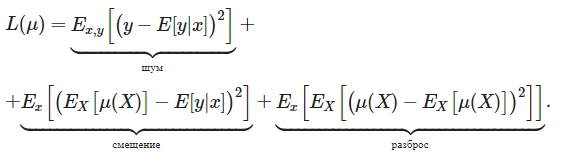

In [12]:
# Аналогично п. 4-7 расчитываем bias & variance для всех оценок
def calculate_bias_variance(classifiers):
    size = len(classifiers)
    
    res = pd.DataFrame()
    res['classifier'] = np.zeros(size)
    res['empirical_risk_bias'] = np.zeros(size)
    res['empirical_risk_var'] = np.zeros(size)
    res['error_prob_bias'] = np.zeros(size)
    res['error_prob_var'] = np.zeros(size)
    res['moving_average_bias'] = np.zeros(size)
    res['moving_average_var'] = np.zeros(size)

    for i, classifier in enumerate(classifiers):
        res.loc[i, 'classifier'] = i

        frame = generate_dataframe(100, 100)
        
        X = df.iloc[:, 1:]
        y = df['class']
        
        _, bias, var = bias_variance_decomp(classifier, X.values, y.values, X.values, y.values, loss='mse', random_seed=0)
        res.loc[i, 'empirical_risk_bias'] = bias
        res.loc[i, 'empirical_risk_var'] = var
        
        df_test = generate_dataframe(10000, 10000)
        X_test = df_test.iloc[:,1:]
        y_test = df_test['class']
        _, bias, var = bias_variance_decomp(classifier, X.values, y.values, X_test.values, y_test.values, loss='mse', random_seed=0)
        res.loc[i, 'error_prob_bias'] = bias
        res.loc[i, 'error_prob_var'] = var
        
        biases = []
        variances = []
        kf = KFold(n_splits=5, shuffle=False)
        for train_index, test_index in kf.split(y):
            X_train_sub = np.take(X, train_index, axis=0)
            X_test_sub = np.take(X, test_index, axis=0)
            y_train_sub = np.take(y, train_index)
            y_test_sub = np.take(y, test_index)

            mse, bias, variance = bias_variance_decomp(classifier, X_train_sub.values, y_train_sub.values, X_test_sub.values, y_test_sub.values, loss='mse', random_seed=0)
            biases.append(bias)
            variances.append(variance)

        res.loc[i, 'moving_average_bias'] = np.mean(biases)
        res.loc[i, 'moving_average_var'] = np.mean(variances)
    
    return res

def draw_diagram(x, y, data):
    df = data[[x]+y].melt(id_vars=[x], value_name='values', var_name='legend')
    sns.catplot(data=df, x=x, y='values', hue='legend', kind="bar")

Рассмотрим зависимость bias и variance от параметров классификатора

1. Количество деревьев

In [13]:
classifiers = [ensemble.RandomForestClassifier(n_estimators=1, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=10, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=20, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0, max_samples=50)]
statistics = calculate_bias_variance(classifiers)
statistics

,classifier,empirical_risk_bias,empirical_risk_var,error_prob_bias,error_prob_var,moving_average_bias,moving_average_var
0,0.0,0.034020,0.065480,0.063509,0.076941,0.080813,0.084762
1,1.0,0.019383,0.024817,0.044986,0.034943,0.063744,0.042981
2,2.0,0.017517,0.019158,0.042326,0.027514,0.062432,0.037518
3,3.0,0.016902,0.015523,0.041720,0.020829,0.064044,0.029181
4,4.0,0.016442,0.014708,0.045666,0.018812,0.067087,0.027812


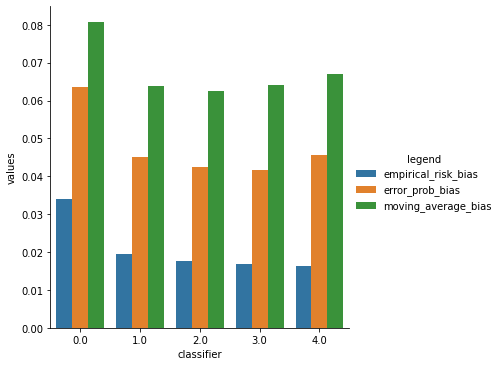

In [14]:
# bias
draw_diagram('classifier', ['empirical_risk_bias', 'error_prob_bias', 'moving_average_bias'], statistics)

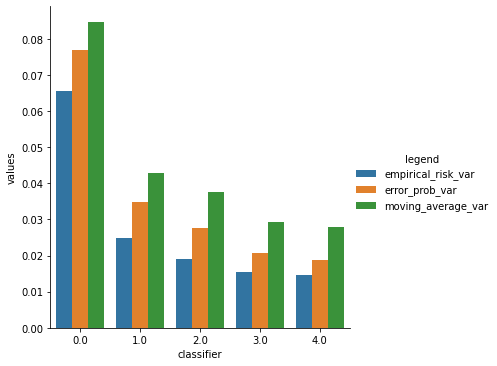

In [15]:
# variance
draw_diagram('classifier', ['empirical_risk_var', 'error_prob_var', 'moving_average_var'], statistics)

2. Количество сэмплов для бутстрапа

In [16]:
classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=10),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=20),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=80),
               ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=100)]
statistics = calculate_bias_variance(classifiers)
statistics

,classifier,empirical_risk_bias,empirical_risk_var,error_prob_bias,error_prob_var,moving_average_bias,moving_average_var
0,0.0,0.033507,0.028318,0.047199,0.031958,0.076480,0.054120
1,1.0,0.025175,0.021050,0.043843,0.025016,0.063086,0.038764
2,2.0,0.017484,0.016966,0.044568,0.023287,0.063012,0.032963
3,3.0,0.012528,0.017722,0.045045,0.024092,0.064181,0.032619
4,4.0,0.010445,0.017530,0.042855,0.024356,0.064639,0.032736


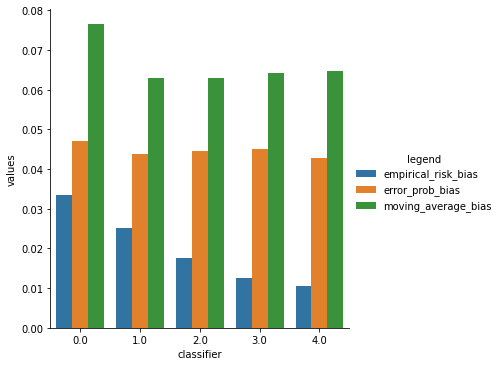

In [17]:
# bias
draw_diagram('classifier', ['empirical_risk_bias', 'error_prob_bias', 'moving_average_bias'], statistics)

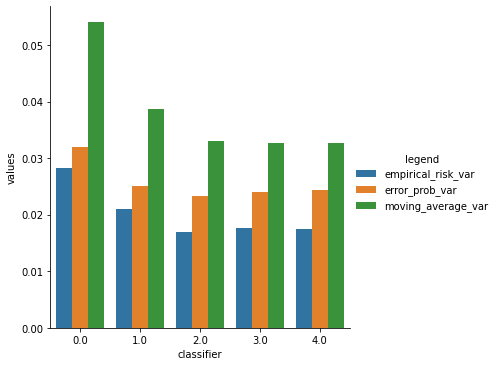

In [18]:
# variance
draw_diagram('classifier', ['empirical_risk_var', 'error_prob_var', 'moving_average_var'], statistics)

Стоит зметить, что variance начинает расти после max_samples=50, что может также свидетельствовать о повышении вероятности переобучения с увеличением max_samples

Сравним bias & variance у RandomForest с другими классификаторами

In [19]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC

In [20]:
classifiers = [ensemble.RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0, max_samples=50),
               QuadraticDiscriminantAnalysis(),
               SVC(kernel='linear', C=1.0)
              ]
statistics = calculate_bias_variance(classifiers)
statistics

,classifier,empirical_risk_bias,empirical_risk_var,error_prob_bias,error_prob_var,moving_average_bias,moving_average_var
0,0.0,0.017484,0.016966,0.043276,0.023469,0.063012,0.032963
1,1.0,0.032680,0.007720,0.036147,0.012415,0.054814,0.016886
2,2.0,0.044273,0.011152,0.053960,0.014978,0.066560,0.019215


QDA: метод, предполагающий, что признаки объектов имеют нормальное распределение, что полностью соответствует нашему случаю.

SVC: метод опорных векторов, основывается на построении разделяющей плоскости в пространстве признаков и классификации объектов исходя из их положения относительно ее.

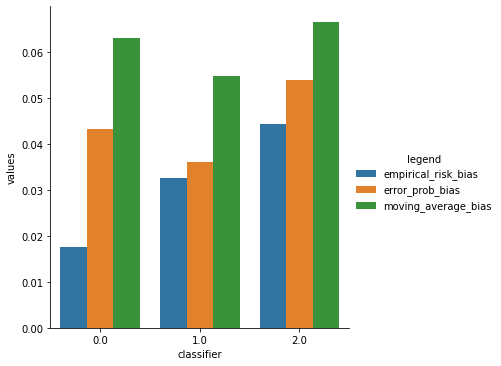

In [21]:
# bias
draw_diagram('classifier', ['empirical_risk_bias', 'error_prob_bias', 'moving_average_bias'], statistics)

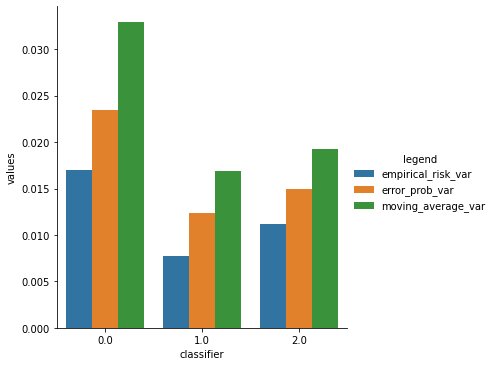

In [22]:
# variance
draw_diagram('classifier', ['empirical_risk_var', 'error_prob_var', 'moving_average_var'], statistics)

Random forest имеет наибольший variance, поскольку дерево чувствительно к изменению данных, т.к. оно буквально смотрит на данные и находит наиболее информативное деление, а при изменении данных более информативным может стать другой признак или другое пороговое значение.

QDA имеет наимееньшие средние по трем метрикам bias & variance поскольку наилучшим образом соответствует распределению признаков.